In [1]:
%load_ext autoreload
%autoreload 2
from src.catalogs import (
    JapanSlowSlipCatalog,
)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

import src
from pathlib import Path
base_dir = Path(src.__file__).parents[1]

mpl.rc('figure',dpi=200)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=8)

In [2]:
%matplotlib widget

In [15]:
dir(japan)

['_Catalog__mag_completeness',
 '_Catalog__mag_completeness_method',
 '__add__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getslice__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__radd__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__update__',
 '__weakref__',
 '_add_duration_column',
 '_add_time_column',
 '_stress_drop',
 'catalog',
 'dir_name',
 'duration',
 'end_time',
 'filter_duplicates',
 'get_japan_trench',
 'get_nankai_trough',
 'get_neighboring_indices',
 'get_polygon_slice',
 'get_ryukyu_trench',
 'get_space_slice',
 'get_time_slice',
 'intersection',
 'japan_trench_bounding_polygon',
 'latitude_range',
 'longitude_range',
 'mag_completeness',
 'name',
 'nankai_trough_bounding_polygon',


In [9]:
japan = JapanSlowSlipCatalog()
japan.mag_completeness = 6
nankai = japan.get_nankai_trough()
refs = nankai.catalog.ref.unique()

/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from r

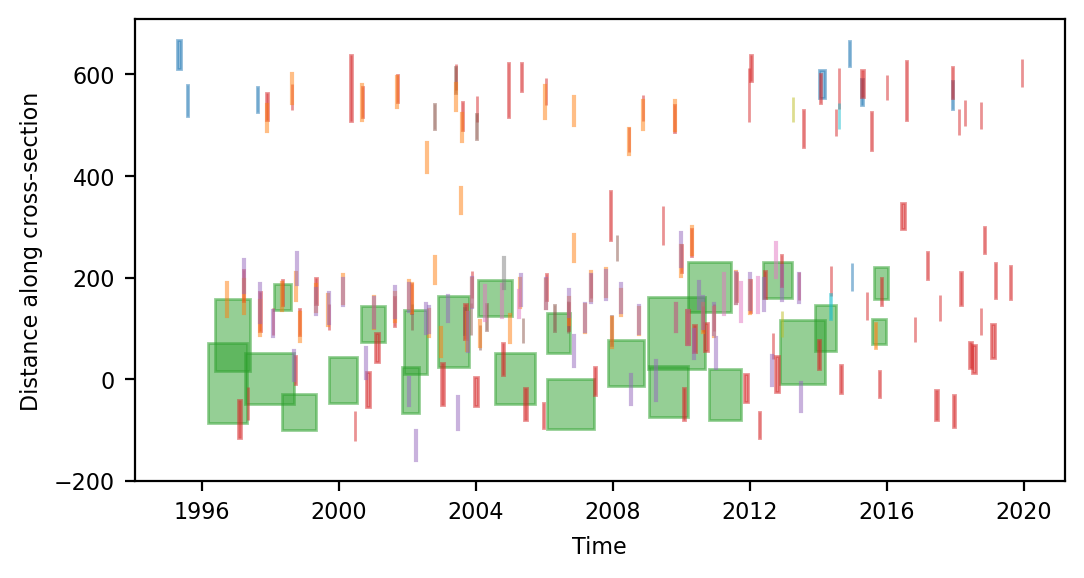

In [10]:
colors = sns.color_palette("deep", len(refs))
fig, ax = plt.subplots(1,1,figsize=(6,3))
colors = sns.color_palette("tab10", len(refs))
for ref, i_color in zip(refs, colors):
    japan.get_nankai_trough(ref).plot_space_time_series(p1=[132,32.5],p2=[138,35], ax=ax, kwargs=dict(color=i_color))
    

In [11]:
unique_nankai = nankai.filter_duplicates(
    buffer_radius_km = 70,
    buffer_time_days = 40,
    stategy='reference',
    ref_preference = nankai.catalog.groupby('ref').max().time.sort_values(ascending=False).index
)

In [12]:
print(f'Number of events: {len(nankai)}')
print(f'Number of unique events: {len(unique_nankai)}')

Number of events: 249
Number of unique events: 156


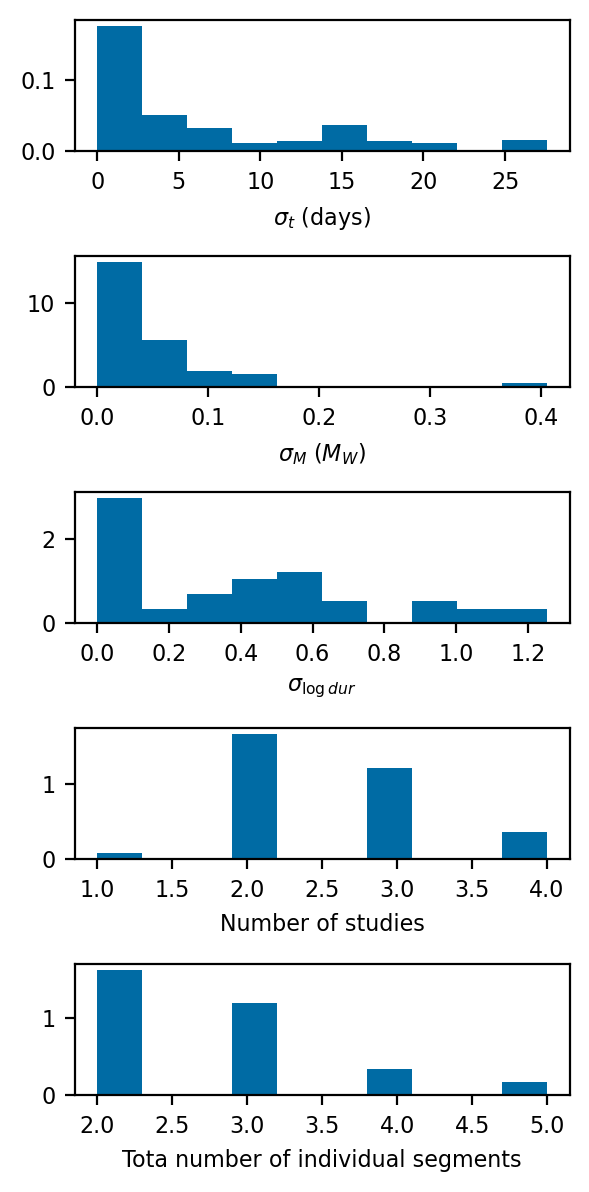

In [13]:
%matplotlib inline
indices = nankai.intersection(
    nankai,
    buffer_radius_km=70,
    buffer_time_days=40,
    return_indices=True,    
)[1]

sigma_t = []
sigma_M = []
sigma_duration = []
num_ref = []
segments = []
sigma_segments = []

number_of_unique_detections = 0
number_events_with_multiple_detections = 0

for i in indices:
    
    # Consider events that have multiple segments withing the prescribed buffer
    if len(i)>1:
        unique_refs = nankai.catalog.iloc[i].ref.unique()
        num_ref.append(len(unique_refs))
        
        if len(unique_refs)==1:
            number_of_unique_detections += len(i)
        else:
            number_events_with_multiple_detections += 1
        
        
        _segments = []
        _mags = []
        _times = [] 
        for iref in unique_refs:
            _segments.append((nankai.catalog.iloc[i].ref == iref).sum())
            mags = nankai.catalog.iloc[i].mag[nankai.catalog.iloc[i].ref == iref]
            t = nankai.catalog.iloc[i].time[nankai.catalog.iloc[i].ref == iref]
            
            if len(mags)>1:
                moments = 10**(1.5*mags-9.1)
                _mags.append(2/3*(np.log10(moments.sum())+9.1))
            else:
                _mags.append(mags.values[0])
                
        sigma_segments.append(_segments)
        sigma_M.append(np.std(_mags))
        
            
            
        segments.append(len(i))
        sigma_t.append(nankai.catalog.iloc[i].time.std()/np.timedelta64(1,'D'))
        sigma_duration.append(np.log10(nankai.catalog.iloc[i].duration).std())
    else:
        number_of_unique_detections += 1
        
fig, AX = plt.subplots(5,1,figsize=(3,6))
for iax,v,k in zip(
    AX,
    [sigma_t, sigma_M, sigma_duration, num_ref, segments], 
    ['$\sigma_t$ (days)', '$\sigma_M$ ($M_W$)', '$\sigma_{\log dur}$ ', 'Number of studies', 'Tota number of individual segments']
):
    
    iax.hist(v, density=True)
    iax.set_xlabel(k)
    
plt.tight_layout()

